# CS:GO Data analysis #

[*Link to the dataset (kaggle)*](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage/data#esea_master_grenades_demos.part1.csv)

[*Link to gitlab repository*](https://gitlab.com/rob.monteremal/r_csgo.git)


In [2]:
# Installs (only do it once per computer)
# install.packages('dplyr')
# install.packages('ggplot2')

# Imports
library('plyr')
library('dplyr')
library('ggplot2')


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# Opening a file from the dataset (first 5 rows for exploration)
filename = "dataset/esea_meta_demos.part1.csv"
df = read.csv(filename, header=TRUE, sep=",", nrows = 5)

# Print its header and content
head(df)

file                    map         round start_seconds end_seconds
1 esea_match_13770997.dem de_overpass 1      94.30782     160.9591   
2 esea_match_13770997.dem de_overpass 2     160.95910     279.3998   
3 esea_match_13770997.dem de_overpass 3     279.39980     341.0084   
4 esea_match_13770997.dem de_overpass 4     341.00840     435.4259   
5 esea_match_13770997.dem de_overpass 5     435.42590     484.2398   
  winner_team      winner_side      round_type   ct_eq_val t_eq_val
1 Hentai Hooligans Terrorist        PISTOL_ROUND  4300      4250   
2 Hentai Hooligans Terrorist        ECO           6300     19400   
3 Hentai Hooligans Terrorist        SEMI_ECO      7650     19250   
4 Hentai Hooligans Terrorist        NORMAL       24900     23400   
5 Animal Style     CounterTerrorist ECO           5400     20550

### Content of each file ###
* ***map_data.csv***: contains the 3d-box coordinates of each map
* ***mm_grenades_demos.csv***: contains data of each grenade throw of each demo
    * *Ex row 1*: T player (rank MGE) threw a **decoy grenade** 25 seconds into the round 1 (pistol round), won by the CT side on de_dust2
* ***mm_master_demos.csv***: contains data of each connecting shot (hit) of each demo
    * *Ex row 1*: CT player (rank SMFC) shot T player (rank SMFC) in the **head** in round 1 (pistol round), won by the CT side on de_dust2
* ***mm_master_demos.csv***: contains data of each connecting shot (hit) of each demo
    * *Ex row 1*: CT player (rank SMFC) shot T player (rank SMFC) in the **head** in round 1 (pistol round), won by the CT side on de_dust2
* ***esea_meta_demos.part1.csv***: contains metadata used for the ESEA demos
* ***esea_master_dmg_demos.part1.csv***: contains data of each damage dealt (self damage included)
* ***esea_master_kills_demos.part1.csv***: contains data of each kill
    * *Ex row 1*: CT player (team Animal Style) killed T player (team Hentai Hooligans) with a **USP** in round 1 (pistol round), resulting in a 5v4 won by the T side (team Hentai Hooligans)
* ***esea_master_grenades_demos.part1.csv***: contains data of each kill
    * *Ex row 1*: CT player (team Animal Style) threw a **smoke grenade** in round 1, doing 0 damage, while the bomb was planted

### Reading datasets ###
*Do not modify those variables*

In [4]:
# Matchmaking demos
# filename = "dataset/mm_master_demos.csv"
# df_mm = read.csv(filename, header=TRUE, sep=",", nrows = -1)

# Esea demos meta files
filename = "dataset/esea_meta_demos.part1.csv"
df1 = read.csv(filename, header=TRUE, sep=",")
filename = "dataset/esea_meta_demos.part2.csv"
df2 = read.csv(filename, header=TRUE, sep=",")

# Append both dataframes
df_esea = rbind(df1, df2)

### Setting the choice of dataset ###
- **df_esea** for ESEA data
- **df_mm** for matchmaking data

In [5]:
#df = df_mm
df = df_esea

### Map distribution in the dataset ###

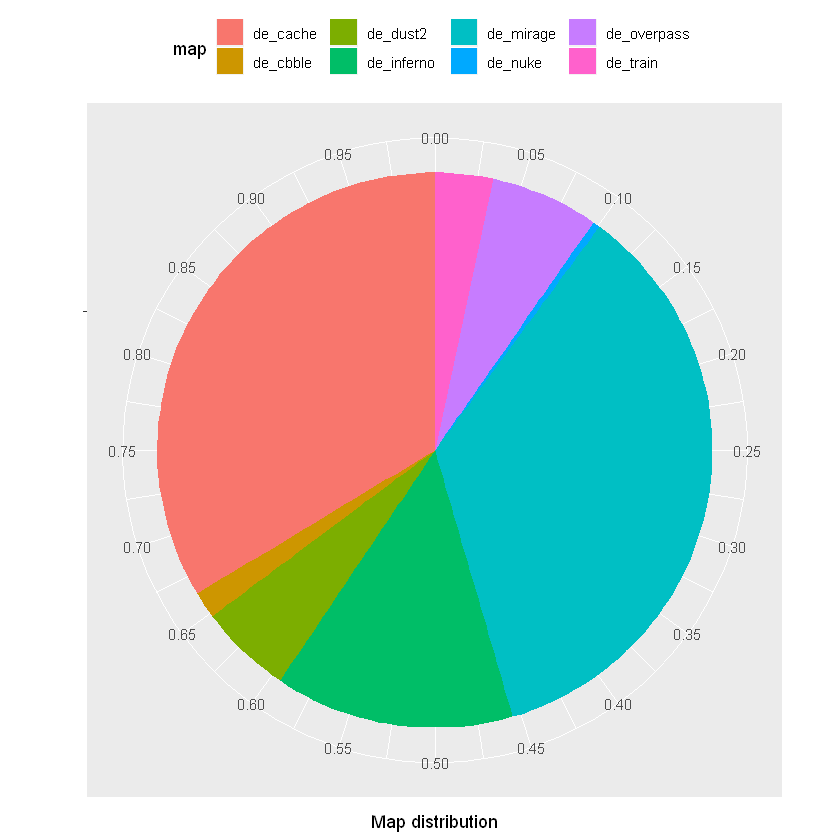

In [6]:
# Remove duplicate data, going from one entry per hit to one entry per game
df_duplicates = df[c("file")]
new_df = df[!duplicated(df_duplicates), ]
map_distrib = count(new_df, map)
map_distrib = mutate(map_distrib, n = n/sum(n))

bp <- ggplot(map_distrib, aes(x="", y=n, fill=map)) +
  geom_bar(width = 1, stat = "identity") +
  theme(legend.position = "top") +
  coord_polar("y", start=0) +
  scale_x_discrete(name="") +
  scale_y_continuous(name="Map distribution", breaks=seq(0,0.95,0.05))
bp

### Analysing round win probability per map ###

In [7]:
# Remove duplicate data, going from one entry per hit to one entry per round
df_duplicates = df[c("file", "round")]
new_df = df[!duplicated(df_duplicates), ]

# Extracting only relevant data
new_df = new_df[,c("file", "round", "winner_side", "map") ]

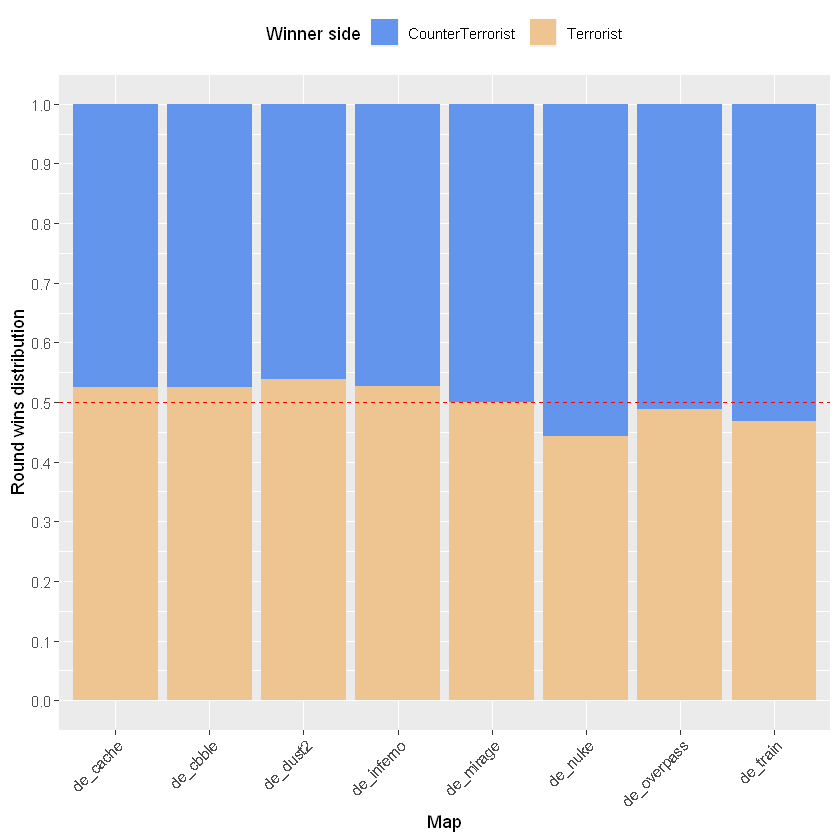

In [8]:
# Count winning side distribution on each map
df_count = count(new_df, map, winner_side)

# Remove "None" data (draw should be impossible..)
df_count = df_count[(which(df_count$winner_side != "None")),]

# Plot the data
ggplot(df_count, aes(fill=winner_side, y=n, x=map)) +
  geom_bar(position="fill", stat="identity") +
  theme(legend.position="top",axis.text.x = element_text(angle=45, hjust=1)) +
  scale_fill_manual("Winner side", values = c("CounterTerrorist" = "cornflowerblue", "Terrorist" = "burlywood2")) +
  scale_x_discrete(name="Map") +
  scale_y_continuous(name="Round wins distribution", breaks=seq(0,1,0.1)) +
  geom_abline(slope=0, intercept=0.5,  col="red", lty=2)

### Analysing pistol round impact on the result of the half ###

In [28]:
# Remove duplicate data, going from one entry per hit to one entry per round
df_duplicates = df[c("file", "round")]
new_df = df[!duplicated(df_duplicates), ]

# Extracting only relevant data
new_df = new_df[,c("file", "round", "winner_side", "map", "winner_team", "round_type") ]

# Grouping data by match
grp_df = group_by(new_df, file)
nrow(grp_df)

[1] 377629

#### Data cleanup ####
Total loss of data = **~30%**

In [29]:
# Each match where the data on either pistol round is unavailable is removed (~17%)
grp_df = filter(grp_df, sum(round %in% c(1,16)) == 2)
# Remove matches where a round is missing (~20%)
grp_df = filter(grp_df, n() == max(round))
# Overtime data is removed (match is considered as ending at 15-15)
grp_df = grp_df[which(grp_df$round <= 30),]
# Remove matches where no one won (data collection ended before the game), either a team won with 16 rounds or the game ended 15-15
grp_df = filter(grp_df, sum(winner_team == "Team 1") == 16 | sum(winner_team == "Team 2") == 16 | (sum(winner_team == "Team 2") == 15 & sum(winner_team == "Team 1") == 15) )
# Round marked as PISTOL_ROUND while it isn't either the 1st or 16th round
grp_df = filter(grp_df, !(!(round %in% c(1,16)) & round_type=="PISTOL_ROUND"))
# Add half data
grp_df = mutate(grp_df, half = (round<=15) + 2 * (round>15))

#### Counting and reformating ####

In [30]:
# Wins are counted for each team on each side
ct_win_df = count(grp_df[which(grp_df$winner_side == "CounterTerrorist"),], half)
t_win_df = count(grp_df[which(grp_df$winner_side == "Terrorist"),], half)
# Rename counting variables (default name is "n")
names(ct_win_df)[names(ct_win_df) == "n"] = "ct_wins"
names(t_win_df)[names(t_win_df) == "n"] = "t_wins"
# Merge the 2 dataframes to have both CT and T wins on each side, with 0 when a team hasn't won a single round in a side
win_df = merge(ct_win_df[,c("file","half", "ct_wins")], t_win_df[,c("file","half", "t_wins")], all = TRUE)
win_df[is.na(win_df)] = 0

In [31]:
# Extracts the winner each pistol round and renames the column
pistol_round_df = filter(grp_df, round==1 | round==16)[,c("file", "half", "winner_side", "map")]
names(pistol_round_df)[names(pistol_round_df) == "winner_side"] = "pistol_winner"
# Merge the 2 dataframes
final_df = merge(win_df, pistol_round_df)

In [32]:
# Counting the data
ct_win = cbind(half_winner="CounterTerrorist", count(filter(final_df, ct_wins > t_wins), pistol_winner))
t_win = cbind(half_winner="Terrorist", count(filter(final_df, ct_wins < t_wins), pistol_winner))
tie = cbind(half_winner="Tie", count(filter(final_df, ct_wins == t_wins), pistol_winner))

count_df = group_by(rbind(ct_win,tie,t_win), pistol_winner)

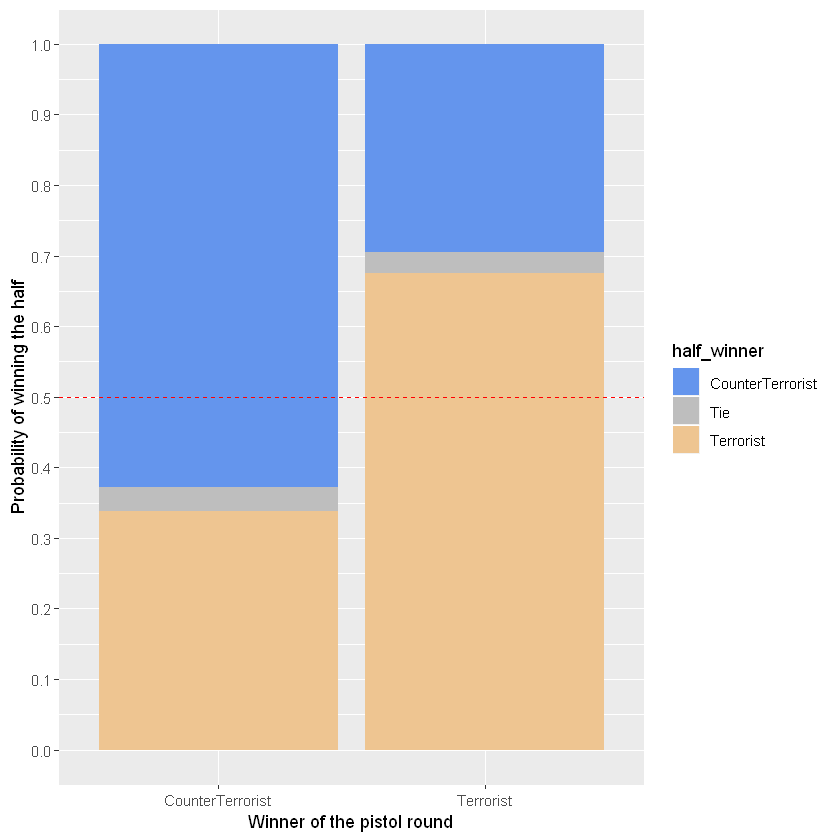

In [33]:
# Plotting the data
ggplot(count_df, aes(fill=half_winner, y=n, x=pistol_winner)) +
  geom_bar(position="fill", stat="identity") +
  scale_fill_manual(values = c("CounterTerrorist" = "cornflowerblue","Tie" = "gray", "Terrorist" = "burlywood2")) +
  scale_x_discrete(name="Winner of the pistol round") +
  scale_y_continuous(name="Probability of winning the half" ,breaks=seq(0,1,0.1)) +
  geom_abline(slope=0, intercept=0.5,  col="red", lty=2)

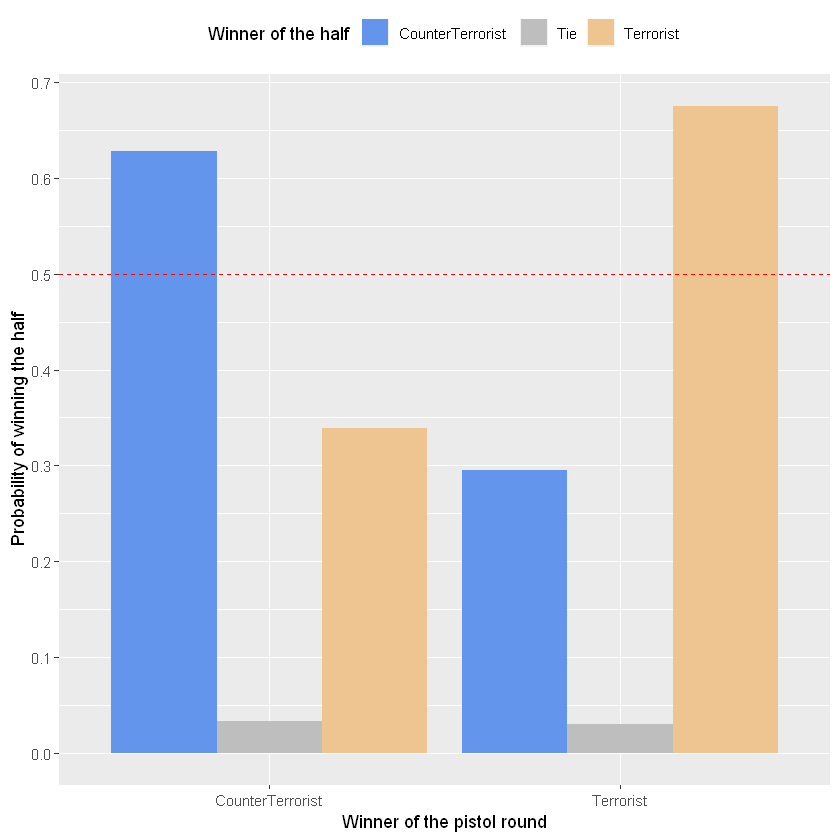

In [43]:
count_df2 = mutate(count_df, half_winning_probability = n/sum(n))

# Plotting the data
ggplot(count_df2, aes(fill=half_winner, y=half_winning_probability, x=pistol_winner)) +
  geom_bar(position=position_dodge(), stat="identity") +
  theme(legend.position="top") +
  scale_fill_manual("Winner of the half", values = c("CounterTerrorist" = "cornflowerblue","Tie" = "gray", "Terrorist" = "burlywood2")) +
  scale_x_discrete(name="Winner of the pistol round") +
  scale_y_continuous(name="Probability of winning the half" ,breaks=seq(0,1,0.1)) +
  geom_abline(slope=0, intercept=0.5,  col="red", lty=2)

### Analysing pistol round impact on the result of the half, per map ###

In [16]:
# Each match where the data on either pistol round is unavailable is removed (~17%)
grp_df = filter(grp_df, sum(round %in% c(1,16)) == 2)
# Overtime data is removed (match is considered as ending at 15-15)
grp_df = grp_df[which(grp_df$round <= 30),]
# Remove matches where a round is missing (~12%)
grp_df = filter(grp_df, n() == max(round))
# Round marked as PISTOL_ROUND while it isn't either the 1st or 16th round
grp_df = filter(grp_df, !(!(round %in% c(1,16)) & round_type=="PISTOL_ROUND"))
# Add half data
grp_df = mutate(grp_df, half = (round<=15) + 2 * (round>15))

In [17]:
# Wins are counted for each team on each side
ct_win_df = count(grp_df[which(grp_df$winner_side == "CounterTerrorist"),], half)
t_win_df = count(grp_df[which(grp_df$winner_side == "Terrorist"),], half)
# Rename counting variables (default name is "n")
names(ct_win_df)[names(ct_win_df) == "n"] = "ct_wins"
names(t_win_df)[names(t_win_df) == "n"] = "t_wins"
# Merge the 2 dataframes to have both CT and T wins on each side, with 0 when a team hasn't won a single round in a side
win_df = merge(ct_win_df[,c("file","half", "ct_wins")], t_win_df[,c("file","half", "t_wins")], all = TRUE)
win_df[is.na(win_df)] = 0

In [18]:
# Extracts the winner each pistol round and renames the column
pistol_round_df = filter(grp_df, round==1 | round==16)[,c("file", "half", "winner_side", "map")]
names(pistol_round_df)[names(pistol_round_df) == "winner_side"] = "pistol_winner"
# Merge the 2 dataframes
final_df = merge(win_df, pistol_round_df)

In [19]:
# Counting the data
ct_win = cbind(half_winner="CounterTerrorist", count(filter(final_df, ct_wins > t_wins), pistol_winner, map))
t_win = cbind(half_winner="Terrorist", count(filter(final_df, ct_wins < t_wins), pistol_winner, map))
count_df = group_by(rbind(ct_win,t_win), pistol_winner)

In [20]:
# Extracts the winner each pistol round and renames the column
pistol_round_df = filter(grp_df, round==1 | round==16)[,c("file", "half", "winner_side", "map")]
names(pistol_round_df)[names(pistol_round_df) == "winner_side"] = "pistol_winner"

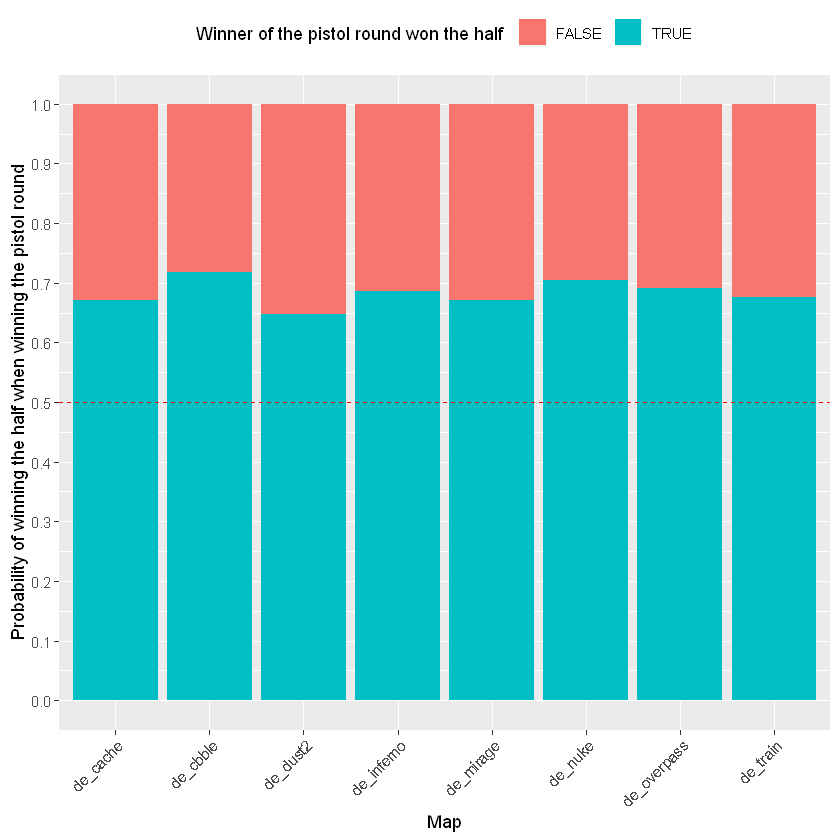

In [21]:
# Evaluates if the pistol round winner won the half or not and adds the result as a column 
count_same_df = mutate(count_df, same = (as.character(pistol_winner) == as.character(half_winner) ) )[,c("same", "map", "n")]

# Plotting the data
ggplot(count_same_df, aes(fill=same, y=n, x=map) ) +
  geom_bar(position="fill", stat="identity") +
  theme(legend.position = "top", axis.text.x = element_text(angle=45, hjust=1)) +
  scale_fill_discrete("Winner of the pistol round won the half") +
  scale_x_discrete(name="Map") +
  scale_y_continuous(name="Probability of winning the half when winning the pistol round", breaks=seq(0,1,0.1)) +
  geom_abline(slope=0, intercept=0.5,  col="red", lty=2)

#### Extending pistol round win to map win ####

In [22]:
# Counting the number of round won per team
raw_df = mutate(grp_df, t1_wins=sum(winner_team == "Team 1"), t2_wins=sum(winner_team == "Team 2"))[, c("file", "map", "t1_wins", "t2_wins")]
team_wins_df = raw_df[!duplicated(raw_df$file),]

# Extracts the winner each pistol round and renames the column
pistol_round_df = filter(grp_df, round==1 | round==16)[,c("file", "half", "winner_team", "map")]
names(pistol_round_df)[names(pistol_round_df) == "winner_team"] = "pistol_winner"

# Merging with the pistol data
final_df = merge(team_wins_df, pistol_round_df)

In [23]:
# Marking the data with the proper game winner
t1_win = cbind(game_winner="Team 1", filter(final_df, t1_wins == 16))[,c("file", "map", "game_winner", "half", "pistol_winner")]
t2_win = cbind(game_winner="Team 2", filter(final_df, t2_wins == 16))[,c("file", "map", "game_winner", "half", "pistol_winner")]
merged_df = rbind(t1_win, t2_win)

# Count the data
merged_df = mutate(group_by(merged_df, file), nb_pistol_won = sum(as.character(pistol_winner) == as.character(game_winner)))
count_df = count(group_by(ungroup(merged_df), map), map, nb_pistol_won)

In [24]:
# Calculating the probability of winning a game by winning x number of pistol rounds
# Remember: for each game won with 1 pistol round, there is a game lost with 1 pistol round (opposite team)
#     for each game won with 2 pistol rounds, there is a game lost with 0 pistol round (opposite team)
#     for each game won with 0 pistol round, there is a game lost with 2 pistol rounds (opposite team)
count_df2 = mutate(filter(count_df, nb_pistol_won == 0 | nb_pistol_won == 2), n = n/sum(n))
count_df1 = mutate(filter(count_df, nb_pistol_won == 1), n = n/(2*sum(n)) )
count_df = rbind(count_df1, count_df2)

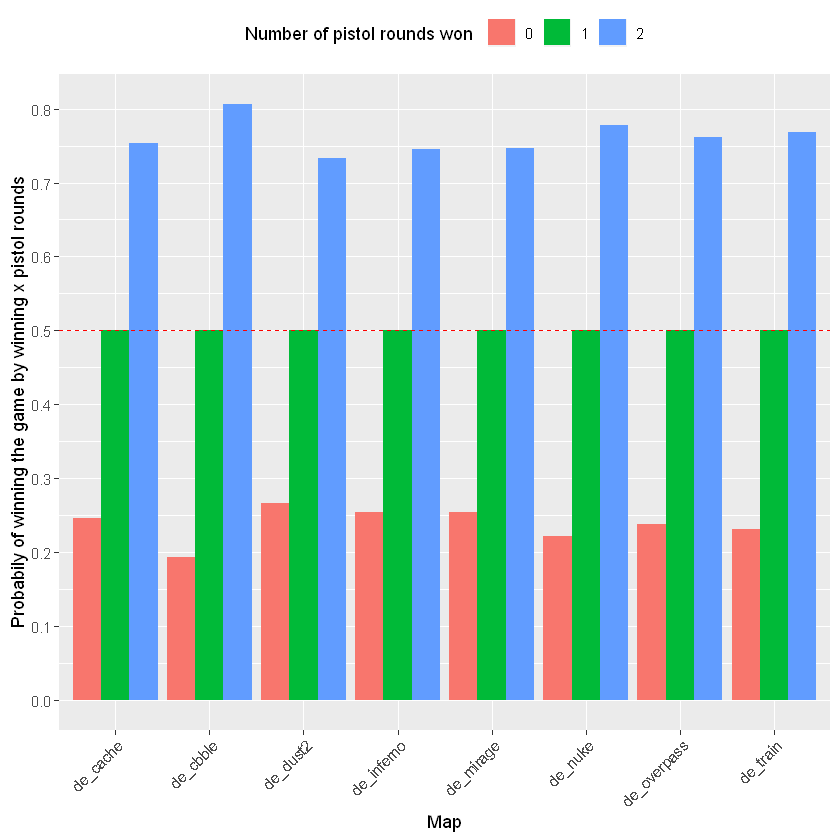

In [25]:
# Plotting the data
ggplot(count_df, aes(fill=factor(nb_pistol_won), y=n, x=map) ) +
  geom_bar(position=position_dodge(), stat="identity") +
  theme(legend.position="top", axis.text.x = element_text(angle=45, hjust=1)) +
  scale_fill_discrete("Number of pistol rounds won") +
  scale_x_discrete(name="Map") +
  scale_y_continuous(name="Probabily of winning the game by winning x pistol rounds", breaks=seq(0,1,0.1)) +
  geom_abline(slope=0, intercept=0.5,  col="red", lty=2)